In [1]:
from IPython.display import clear_output
import mesa
import scipy.optimize as opt
import ipynb
import math
import numpy as np
from functools import reduce
clear_output(wait=True)
print("Everything imported!")


Everything imported!


In [2]:
from mesa import Agent
import random

class RandomWalker(Agent):
    def __init__(self, unique_id, model, pos):
        super().__init__(unique_id, model)

        self.pos = pos

    def move(self,target_pos,vision):
        heading=self.model.grid.get_heading(self.pos,target_pos)
        next_pos=tuple(np.array(heading)*(1+vision/2))
        self.model.grid.move_agent(self,next_pos)
        
    #generate a random position in a vision*vision square
    def _random_pos(self,vision):
        return tuple(np.array(self.pos)+(np.random.rand(2)-0.5)*vision)
    
    def random_move(self,vision):
        self.model.grid.move_agent(self,self._random_pos(vision))
        

In [3]:
class Individual(RandomWalker):
    def __init__(self, unique_id, model, pos, 
                 sex, income, level, generation,clan,generation_in_clan):
        super().__init__(unique_id, model, pos)
        self.sex=sex  #False:male, True:Female
        self.income=income
        self.marriage=False 
        self.investment=(0,0) #(male_investment, female_investment)
        self.clan=clan # family id
        self.generation_in_clan=generation_in_clan # generation in a certain family
        self.children=(0,0)  #(male_count, female_count)
        self.generation=generation  #current generation in population
        self.level=level #0->4 low->high
        self.vision=self.model.vision
        self.current_step=0

    def _find_nearest(self,pos,neighbors):
        
        # find opposite gender satisfying following conditions
        op_gender=list(filter(lambda n:(n.sex^self.sex) 
                                and (not n.marriage)
                                and n.generation==self.generation #only find hetersexual at the same generation 
                                and n.clan != self.clan #matting in family is forbidden
                                and n.level==self.level #find 
                                ,neighbors))
        incomes=list(map(lambda n:n.income,op_gender))
        if len(incomes)==0:
            return None
        i=np.argmax(incomes) 
        return op_gender[i]
    
    
    # reproduction plan
    def get_plan(self,neighbors):
        male_u, female_u=self.model.get_utility()
        reproduce_plan=[]
        plan_utility=[]
        n_i=self.get_neighbor_investment(neighbors) 
        
        #compute competitiveness independently
        #formula: current_investment / average_investment_of_neighbors (including self)
        compet_male=lambda c,x:1 if((n_i[2]+x[0])==0 or n_i[0]+c[0]==0) else x[0]/((n_i[2]+x[0])/(n_i[0]+c[0]))
        compet_female=lambda c,x:1 if((n_i[3]+x[1])==0 or n_i[1]+c[1]==0) else x[1]/((n_i[3]+x[1])/(n_i[1]+c[1]))
        
        #compute investment plan for all family combinations
        for c in self.model.family_set:
            target=lambda x:-(c[0]*x[0]*male_u*compet_male(c,x)+c[1]*x[1]*female_u*compet_female(c,x)) #explanation of the formula is in the shared document
            condition=lambda x:self.income-c[0]*x[0]-c[1]*x[1] #total investment is less than parents' total income
            cons=[{"type":"ineq",'fun':condition}]
            bnds=((0.1,None),(0.1,None))  # minimum investment for each kid, adjustable
            res = opt.minimize(target, (1, 1), method='trust-constr', bounds=bnds, constraints=cons,options={'maxiter':10})
            #this condition statement handles exceptions caused by numerical algorithms
            if(res.x[0]<0 or res.x[1]<0):
                res.x=(0,0)
            #structure of plan: ((male,famale),(invest_male, invest_female),(compet_male,compet_female))
            mc=compet_male(c,res.x)
            fc=compet_female(c,res.x)
            reproduce_plan.append((c,(res.x[0],res.x[1]),(mc,fc)))
            plan_utility.append(-target(res.x)) #record function value of 'target', generating distribution
        plan_utility=np.array(plan_utility)
        dist=plan_utility/sum(plan_utility)         
        plan=np.random.choice(list(range(len(dist))),size=1,p=dist)[0] #choose a plan according to target values
        return reproduce_plan[plan]
        
    def get_neighbor_investment(self, neighbors):
        male_count,male_sum,female_count,female_sum=0,0,0,0
        for n in neighbors:
            if((not n.marriage) or (n.generation!=self.generation)):
                continue
            male_count+=n.children[0]
            male_sum+=n.investment[0]*n.children[0]
            female_count+=n.children[1]
            female_sum+=n.investment[1]*n.children[1]
        return male_count,female_count,male_sum,female_sum
            
    def reproduce(self,neighbors):
        children,investment,compet=self.get_plan(neighbors)
        utility=self.model.utilities
        self.investment=investment
        self.children=children
        mc,fc=1,1
        if(self.generation>0): #the first generation has no married neighbors
            mc,fc=compet
        
        if self.level>=5: self.level=4
        expected_income=self.model.level_income[self.level] #expected income is defined by the average income of the parents' level
        male_income=expected_income*mc*utility[0]
        female_income=expected_income*fc*utility[1]
        male_level=self.level
        female_level=self.level
        #if the income value is larger than average income of a higher level, the child upgrades level
        
#         for i in range(self.level+1,5):
#             if(male_income>self.model.level_income[i]):
#                 male_level=i
#             if(female_income>self.model.level_income[i]):
#                 female_level=i
        for i in range(self.level,5):
            if(male_income>self.model.level_income[i]):
                male_level=i+1
            if(female_income>self.model.level_income[i]):
                female_level=i+1
        
        #if the income value is less than average income of a lower level, the child downgrades level
        for i in range(0,self.level):
            if(male_income<self.model.level_income[i]):
                male_level=i
            if(female_income<self.model.level_income[i]):
                female_level=i
                
        next_clan=self.clan #record family identity
        next_g=self.generation_in_clan+1
        if(next_g>3): #if the kid is far from the his/her ancestor, mark him/her as a new family
            next_clan=None
            next_g=0
        
        for i in range(children[0]):
            self.model.new_agent(Male,self.pos,male_income,male_level,self.generation+1,next_clan,next_g)
        for i in range(children[1]):
            self.model.new_agent(Female,self.pos,female_income,female_level,self.generation+1,next_clan,next_g)
    
    
    def step(self):
        self.current_step+=1
        #define agent's life
        if(self.current_step>self.model.max_step):
            self.model.remove_agent(self)
            return 
        if(self.marriage):
            return
        
        neighbors=self.model.grid.get_neighbors(self.pos,self.vision,False)
        candidate=self._find_nearest(self.pos,neighbors)
        if(candidate is None):
            self.random_move(self.vision)
            return
        if(random.random()<self.marriage_chance(candidate)):
            self.income+=candidate.income  #merge income
            self.marriage=True
            self.reproduce(neighbors)
            self.model.remove_agent(candidate) #remove the candidate because one representitive agent is enough for a family
        else:
            self.random_move(self.vision)


class Male(Individual):
    def __init__(self,unique_id, model, pos, 
                 income, level, generation=1,clan=None,generation_in_clan=0):
        super().__init__(unique_id, model, pos, 
                 False, income, level, generation,clan,generation_in_clan)
                
    def marriage_chance(self,candidate):
        return (self.level==candidate.level)
    
        
class Female(Individual):
    def __init__(self,unique_id, model, pos, 
                 income, level, generation=1,clan=None,generation_in_clan=0):
        super().__init__(unique_id, model, pos, 
                 True, income, level, generation,clan,generation_in_clan)
        
    
    def marriage_chance(self,candidate):
        return (self.level==candidate.level)


In [4]:
from mesa import Model
from mesa.space import ContinuousSpace
from mesa.datacollection import DataCollector
from mesa.time import RandomActivation
import itertools as it
def compute_male_income(model):
    male_income=0
    male_count=0
    for agent in model.schedule.agents:
        if(not agent.sex and (not agent.marriage)):
            male_income+=agent.income
            male_count+=1
    if(male_count==0):
        return 0
    return male_income/male_count

def compute_female_income(model):
    female_income=0
    female_count=0
    for agent in model.schedule.agents:
        if(agent.sex and (not agent.marriage)):
            female_income+=agent.income
            female_count+=1
    if(female_count==0):
        return 0
    return female_income/female_count

def male_at_birth(model):
    male_count=0
    for agent in model.schedule.agents:
        male_count+=agent.children[0]
    return male_count

def female_at_birth(model):
    female_count=0
    for agent in model.schedule.agents:
        female_count+=agent.children[1]
    return female_count

###
def gender_ratio(model):
    male_count=0
    female_count=0
    for agent in model.schedule.agents:
        male_count+=agent.children[0]
        female_count+=agent.children[1]
    if female_count ==0: return 
    else: return male_count/female_count
#     male=int(male_at_birth(model))
#     female=int(female_at_birth(model))
#     if female ==0: return 
#     else: return male/female

def male_investment(model):
    m_count=0
    inv=0
    for agent in model.schedule.agents:
        if(agent.marriage):
            if(agent.children[0]>0):
                m_count+=agent.children[0]
                inv+=agent.investment[0]*agent.children[0]
    if(m_count==0):
        return 0
    return inv/m_count
    
def female_investment(model):
    f_count=0
    inv=0
    for agent in model.schedule.agents:
        if(agent.marriage):
            if(agent.children[1]>0):
                f_count+=agent.children[1]
                inv+=agent.investment[1]*agent.children[1]
    if(f_count==0):
        return 0
    return inv/f_count

class SexDistortion(Model):
    
    def __init__(self, height=30, width=30,
                 base_population=1000,planning=3,
                 sex_ratio=110/100,
                 social_level=5,
                 income_bias=0.8,  # income bias, p percent people hold (1-p) percent wealth, adjustable
                 vision=2, initial_utility=(1,0.8)):

        super().__init__()
        
        self.sex_ratio=sex_ratio
        self.social_level=social_level
        self.income_bias=income_bias
        self.height = height
        self.width = width
        self.vision=vision
        self.schedule=RandomActivation(self)
        self.max_step=3
        self.grid = ContinuousSpace(self.width, self.height, torus=True)
        self.datacollector = DataCollector(
             model_reporters={"male_income": compute_male_income,
                              "female_income":compute_female_income,
                              "male_count":male_at_birth,
                              "female_count":female_at_birth,
                              "male_investment":male_investment,
                              "female_investment":female_investment,
                              "gender_ratio": gender_ratio
                             })
        self.utility_counter=-1
        self.utilities=initial_utility
        self.family_set=set()
        i=list(range(int(planning+1)))+list(range(int(planning+1)))  ### changed int()
        p=it.permutations(i,2)
        for c in p:
            if(c[0]+c[1]<=planning):
                self.family_set.add(c)
        self.current_step=0

        self.init_population_v1(base_population)
        self.level_income={} ##
        self.level_count={}  ##

        # This is required for the datacollector to work
        self.running = True
        self.datacollector.collect(self)
        
#     def init_population(self, urban_female):
#         urban_male=math.floor(urban_female*self.urban_sex_ratio)
#         country_female=math.floor(urban_female/self.urban_country_ratio)
#         country_male=math.floor(country_female*self.country_sex_ratio)
#         country_male_income=5
#         urban_male_income=15
#         u=self.utilities[1]/self.utilities[0]
#         for i in range(urban_male):
#             x = random.random()*(self.width)
#             y = random.random()*(self.height)
#             self.new_agent(Male,(x,y),urban_male_income,'urban')
#         for i in range(urban_female):
#             x = random.random()*(self.width)
#             y = random.random()*(self.height)
#             self.new_agent(Female,(x,y),urban_male_income*u,'urban')
#         for i in range(country_male):
#             x = random.random()*(self.width)
#             y = random.random()*(self.height)
#             self.new_agent(Male,(x,y),country_male_income,'country')
#         for i in range(country_female):
#             x = random.random()*(self.width)
#             y = random.random()*(self.height)
#             self.new_agent(Female,(x,y),country_male_income*u,'country')
            
            
    def init_population_v1(self, total):
        
        u=self.utilities[1]/self.utilities[0]
        
        #compute population detail by sex_ratio
        male_count=total*self.sex_ratio/(self.sex_ratio+1)
        female_count=total-male_count
        
        #approximate lorenz curve by staged poisson distribution
        X_male=np.append(np.random.poisson(lam=1, size=math.ceil(male_count*self.income_bias)), 
              np.random.poisson(lam=16, size=math.ceil(male_count*(1-self.income_bias))))
        X_male=np.sort(X_male)
        slot_width=len(X_male)//self.social_level
        for i in range(len(X_male)):
            x = random.random()*(self.width)
            y = random.random()*(self.height)
            self.new_agent(Male,(x,y),X_male[i],i//slot_width)
            
        
        X_female=np.append(np.random.poisson(lam=1*u, size=math.ceil(female_count*self.income_bias)), 
              np.random.poisson(lam=16*u, size=math.ceil(female_count*(1-self.income_bias))))
        X_female=np.sort(X_female)
        slot_width=len(X_female)//self.social_level
        for i in range(len(X_female)):
            x = random.random()*(self.width)
            y = random.random()*(self.height)
            self.new_agent(Female,(x,y),X_female[i],i//slot_width)
    
    #pos, income, residence, generation=1,clan=None,generation_in_clan=0, utility=1.0)
    def new_agent(self, agent_type, pos,income,level,generation=1,clan=None,generation_in_clan=0):
        '''
        Method that creates a new agent, and adds it to the correct scheduler.
        '''
        i=self.next_id()
        if(clan is None):
            clan=i
        agent = agent_type(i, self, pos,income,level,generation,clan,generation_in_clan)

        self.grid.place_agent(agent, pos)
        self.schedule.add(agent)

    def remove_agent(self, agent):
        '''
        Method that removes an agent from the grid and the correct scheduler.
        '''
        self.grid.remove_agent(agent)
        self.schedule.remove(agent)

    def step(self):
        '''
        Method that calls the step method for each of the sheep, and then for each of the wolves.
        '''
        #self.schedule_population.step()
        
        self.stat_level_income()
        self.schedule.step()
        # Save the statistics
        self.datacollector.collect(self)
    
    #refreshing income ratio
    def get_utility(self):
        if(self.current_step>self.utility_counter):
            data = model.datacollector.get_model_vars_dataframe()[-1:]
            print(data)
            a,b=(data["male_income"].to_numpy()[0],data["female_income"].to_numpy()[0])
            self.utilities=(1,b/a)
            self.utility_counter=self.current_step
        return self.utilities
    
    def run_model(self, step_count=15):
        '''
        Method that runs the model for a specific amount of steps.
        '''
        for i in range(step_count):
            print(i)
            self.current_step=i
            self.stat_level_income()
            print(self.level_income)
            print(self.level_count)
            self.step()
        
    def stat_level_income(self):
        level_count={}
        level_sum={}
        for agent in self.schedule.agents:
            if(agent.marriage):
                continue
            level_count[agent.level]=level_count.get(agent.level,0)+1
            level_sum[agent.level]=level_sum.get(agent.level,0)+agent.income
        for i in range(5):
            self.level_income[i]=level_sum.get(i,0)/level_count.get(i,1)
            self.level_count[i]=level_count.get(i,0)

In [5]:
%matplotlib inline
    
model = SexDistortion(height=10, width=10, base_population=1000,planning=2,
                 sex_ratio=110/100,
                 social_level=5,
                 income_bias=0.8,
                 vision=2, initial_utility=(1,0.8))
model.run_model(step_count=3)

data = model.datacollector.get_model_vars_dataframe()

0
{0: 0.0, 1: 0.43, 2: 1.005, 3: 2.125, 4: 14.11}
{0: 200, 1: 200, 2: 200, 3: 200, 4: 200}
   male_income  female_income  male_count  female_count  male_investment  \
0      3.91619       3.188679           0             0                0   

   female_investment gender_ratio  
0                  0         None  


/Users/yuhao/.local/share/virtualenvs/abm-assignments-NQeIrZzw/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


1
{0: 0.0, 1: 0.14696468364644785, 2: 0.6000288822029284, 3: 1.3460619842060433, 4: 6.726398556196116}
{0: 143, 1: 239, 2: 107, 3: 99, 4: 61}
   male_income  female_income  male_count  female_count  male_investment  \
1    10.057687       9.119087         337           356         5.212211   

   female_investment  gender_ratio  
1           4.237906      0.946629  


/Users/yuhao/.local/share/virtualenvs/abm-assignments-NQeIrZzw/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


2
{0: 0.0, 1: 0.033385117275980175, 2: 0.42601253005199496, 3: 1.2702100744058873, 4: 6.151161359973}
{0: 109, 1: 222, 2: 76, 3: 46, 4: 60}
   male_income  female_income  male_count  female_count  male_investment  \
2     9.355306       7.364165         586           572         7.112623   

   female_investment  gender_ratio  
2           6.589508      1.024476  


/Users/yuhao/.local/share/virtualenvs/abm-assignments-NQeIrZzw/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


   male_income  female_income  male_count  female_count  male_investment  \
0     3.916190       3.188679           0             0         0.000000   
1    10.057687       9.119087         337           356         5.212211   
2     9.355306       7.364165         586           572         7.112623   
3     7.700301       4.952706         744           709         7.948003   

   female_investment  gender_ratio  
0           0.000000           NaN  
1           4.237906      0.946629  
2           6.589508      1.024476  
3           7.670430      1.049365  
{0: 0.0, 1: 0.033385117275980175, 2: 0.42601253005199496, 3: 1.2702100744058873, 4: 6.151161359973}
{0: 109, 1: 222, 2: 76, 3: 46, 4: 60}


<AxesSubplot:>

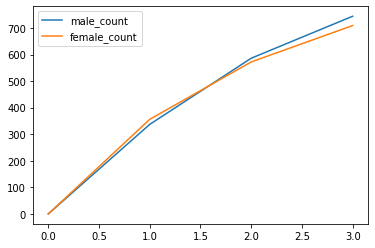

In [6]:
import matplotlib.pyplot as plt
print(data)
print(model.level_income)
print(model.level_count)
data.plot(y=['male_count','female_count'])

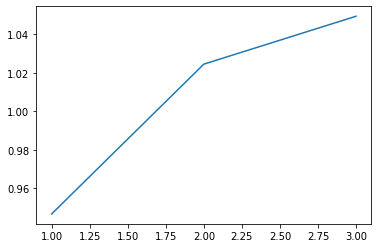

In [7]:
plt.plot(data['gender_ratio'])

In [8]:
# import matplotlib.pyplot as plt
# x0,y0,x1,y1,x2,y2,x3,y3,x4,y4=[],[],[],[],[],[],[],[],[],[]
# for i in model.schedule.agents:
#     p=model.grid.torus_adj(i.pos)
#     if(i.level==1):
#         x1.append(p[0])
#         y1.append(p[1])
#     if(i.level==0):
#         x0.append(p[0])
#         y0.append(p[1])
#     if(i.level==2):
#         x2.append(p[0])
#         y2.append(p[1])
#     if(i.level==3):
#         x3.append(p[0])
#         y3.append(p[1])
#     if(i.level==4):
#         x4.append(p[0])
#         y4.append(p[1])
# plt.scatter(x0,y0,color="b")
# plt.scatter(x1,y1,color="r")
# plt.scatter(x2,y2,color="black")
# plt.scatter(x3,y3,color="green")
# plt.scatter(x4,y4,color="yellow")
# print(len(x0),len(x1),len(x2),len(x3),len(x4))

In [15]:
#SA
from SALib.sample import saltelli
from mesa.batchrunner import BatchRunner
from SALib.analyze import sobol
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

# # We define our variables and bounds
# problem = {
#     'num_vars': 3,
#     'names': ['base_population', 'planning', 'sex_ratio'],
#     'bounds': [[50,100], [1,4], [0.9,1.1]]
# }

# # Set the repetitions, the amount of steps, and the amount of distinct values per variable
# replicates = 1
# max_steps = 10
# distinct_samples = 2

# # Set the outputs
# model_reporters = {"gender_ratio": gender_ratio}

# data = {}

# for i, var in enumerate(problem['names']):
#     # Get the bounds for this variable and get <distinct_samples> samples within this space (uniform)
#     samples = np.linspace(*problem['bounds'][i], num=distinct_samples)
    
#     # Keep in mind that wolf_gain_from_food should be integers. You will have to change
#     # your code to acommodate for this or sample in such a way that you only get integers.
# #     if var == 'wolf_gain_from_food':
# #         samples = np.linspace(*problem['bounds'][i], num=distinct_samples, dtype=int)
    
#     batch = BatchRunner(SexDistortion, 
#                         max_steps=max_steps,
#                         iterations=replicates,
#                         variable_parameters={var: samples},
#                         model_reporters=model_reporters,
#                         display_progress=True)
    
#     batch.run_all()
    
#     data[var] = batch.get_model_vars_dataframe()

In [10]:
#print(data['base_population'])

In [23]:

# We define our variables and bounds
problem = {
    'num_vars': 3,
    'names': ['base_population', 'planning', 'sex_ratio'],
    'bounds': [[500,1000], [1,4], [0.9, 1.1]]
}


# Set the repetitions, the amount of steps, and the amount of distinct values per variable
replicates = 2
max_steps = 5
distinct_samples = 4

# Set the outputs
model_reporters = {"gender_ratio": gender_ratio,
                  "male_count":male_at_birth}
data={}

# We get all our samples here
param_values = saltelli.sample(problem, distinct_samples)

# READ NOTE BELOW CODE
batch = BatchRunner(SexDistortion, 
                    max_steps=max_steps,
                    variable_parameters={name:[] for name in problem['names']},         #{name:[] for name in problem['names']}
                    model_reporters=model_reporters)
count = 0
data = pd.DataFrame(index=range(replicates*len(param_values)), 
                                columns=['base_population', 'planning', 'sex_ratio'])
data['Run'],data['gender_ratio'], data['male_count']= None, None, None

for i in range(replicates):
    for vals in param_values: 
        # Change parameters that should be integers
        vals = list(vals)
        vals[0] = int(vals[0])
        vals[1] = int(vals[1])
        # Transform to dict with parameter names and their values
        variable_parameters = {}
        for name, val in zip(problem['names'], vals):
            variable_parameters[name] = val

        batch.run_iteration(variable_parameters, tuple(vals), count)
        iteration_data = batch.get_model_vars_dataframe().iloc[count]
        iteration_data['Run'] = count # Don't know what causes this, but iteration number is not correctly filled
        data.iloc[count, 0:3] = vals
        data.iloc[count, 3:6] = iteration_data
        count += 1

        clear_output()
        print(f'{count / (len(param_values) * (replicates)) * 100:.2f}% done')

100.00% done


In [24]:
print(data)

   base_population planning sex_ratio   Run gender_ratio male_count
0              609        1  1.003711     0         None          3
1              838        1  1.003711   1.0     1.666667        5.0
2              609        1  1.003711   2.0     1.666667        5.0
3              609        1  1.081445   3.0     1.666667        5.0
4              609        1  1.081445   4.0     1.666667        5.0
..             ...      ...       ...   ...          ...        ...
59             734        3  1.031445  59.0     1.250000       55.0
60             734        1  1.031445  60.0     1.000000       36.0
61             713        3  1.031445  61.0     1.000000       36.0
62             713        1  0.953711  62.0     1.172414       34.0
63             713        1  1.031445  63.0     1.172414       34.0

[64 rows x 6 columns]


In [22]:
Si = sobol.analyze(problem, data['gender_ratio'].values, print_to_console=True)

TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'